<a href="https://colab.research.google.com/github/ATOMconsortium/AMPL/blob/master/atomsci/ddm/examples/tutorials/AMPL_FNL_Wrshp2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  AMPL Workshop2-2: Explore data overlaps & diversity of compound sets

> In this notebook we will be analyzing Histamine Receptor H1 (HRH1) target binding assay measurement datasets  from ChEMBL, DTC and ExCAPE-DB.<br>
ChEMBL: https://www.ebi.ac.uk/chembl/<br>
DTC: https://drugtargetcommons.fimm.fi/<br>
ExCAPE-DB: https://solr.ideaconsult.net/search/excape/ <br>
NCBI Gene information: https://www.ncbi.nlm.nih.gov/gene?Db=gene&Cmd=DetailsSearch&Term=3269


In [1]:
from IPython.display import Image
Image(url='https://github.com/ravichas/AMPL-Tutorial/blob/master/Img/AMPL_smiles_standardization.png?raw=true')

This is a continuation of AMPL Workshop2-1 notebook, https://github.com/ravichas/AMPL-Tutorial/blob/master/AMPL_FNL_Wrshp2_1.ipynb, please review this notebook before you work on this one.  

We assume that the AMPL software (https://github.com/ATOMconsortium/AMPL) is already installed. If you want to try AMPL without installing the software, copy the notebook to your google drive and run the following two code chunks.  

# AMPL Installation


In [ ]:
! pip install rdkit-pypi
! pip install --pre deepchem

import deepchem
# print(deepchem.__version__)
! pip install umap
! pip install llvmlite==0.34.0  --ignore-installed
! pip install umap-learn
! pip install molvs
! pip install bravado

In [ ]:
import deepchem as dc

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

# Load packages

In [4]:
%matplotlib inline
# manipulate data
import pandas as pd

# plot data
import numpy as np
import matplotlib.pyplot as plt

# curate data
from atomsci.ddm.utils import struct_utils
from atomsci.ddm.utils import curate_data
from atomsci.ddm.pipeline import dist_metrics

# visualize data
import seaborn as sns
import matplotlib_venn as mpv
from scipy.stats import pearsonr

# set pandas options
pd.set_option('display.max_columns',(90))
pd.set_option('display.max_rows',(20))

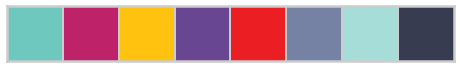

In [5]:
# set up visualization parameters
sns.set_context("poster")
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [10,10]

colors = [
    "#6EC8BE",
    "#BE2369",
    "#FFC30F",
    "#694691",
    "#EB1E23",
    "#7682A4",
    "#A7DDD8",
    "#373C50",
]
# Set your custom color palette
pal=sns.color_palette(colors)
sns.set_palette(pal)
sns.palplot(pal)

## Load ChEMBL Data

In [6]:
! wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/HRH1_ChEMBL_sel.csv >& /dev/null

In [7]:
chembl = pd.read_csv("HRH1_ChEMBL_sel.csv", index_col=0)
chembl.head(3)

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM
0,CHEMBL157217,NaN,0.0,277.46,0.0,4.17,1j,c1nc(CCCCCCCCCCN2CCCC2)c[nH]1,Ki,'=',2.511886e+14,nM,NaN,Outside typical range,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL692992,Inhibitory activity against human Histamine H1...,B,BAO_0000357,single protein format,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL231,Histamine H1 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1145948,1,Scientific Literature,J. Med. Chem.,2003.0,NaN,NaN,2.511886e+14
2,CHEMBL444083,NaN,0.0,562.66,2.0,5.04,1,NC(=O)N(O)CCC#Cc1ccc(OCCCCN2CCN(C(c3ccc(F)cc3)...,Ki,'=',3.630000e+00,nM,8.44,NaN,NaN,UO_0000065,15.00,0.28,3.40,10.26,False,CHEMBL828761,Binding affinity for recombinant human Histami...,B,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,CHO,NaN,NaN,NaN,NaN,CHEMBL231,Histamine H1 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1141893,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2005.0,CHEMBL3308072,NaN,3.630000e+00
3,CHEMBL101691,NaN,0.0,428.55,0.0,3.10,33,O=C(c1ccc(OCCCN2CC[C@H](NS(=O)(=O)c3ccccc3)C2)...,Ki,'=',9.100000e+03,nM,5.04,NaN,NaN,UO_0000065,11.76,0.23,1.94,6.66,False,CHEMBL691613,Binding affinity to the human Histamine H1 rec...,B,BAO_0000357,single protein format,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL231,Histamine H1 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1134928,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2002.0,NaN,NaN,9.100000e+03


# Get DTC data

In [8]:
!wget -O HRH1_DTC_sel.csv https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/HRH1_DTC_sel.csv >& /dev/null

In [9]:
dtc = pd.read_csv("HRH1_DTC_sel.csv", index_col=0)
dtc.head(3)

,compound_id,standard_inchi_key,compound_name,synonym,target_id,target_pref_name,gene_names,wildtype_or_mutant,mutation_info,pubmed_id,standard_type,standard_relation,standard_value,standard_units,activity_comment,ep_action_mode,assay_format,assaytype,assay_subtype,inhibitor_type,detection_tech,assay_cell_line,compound_concentration_value,compound_concentration_value_unit,substrate_type,substrate_relation,substrate_value,substrate_units,assay_description,title,journal,doc_type,annotation_comments,pDTC_Value,SMILES
0,CHEMBL12,AAOVKJBEBIDNHE-UHFFFAOYSA-N,DIAZEPAM,NaN,P35367,HISTAMINE H1 RECEPTOR,HRH1,NaN,NaN,NaN,IC50,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,NaN,NaN,NaN,NaN,NaN,NaN,"DRUGMATRIX: Histamine H1, Central radioligand ...",DrugMatrix in vitro pharmacology data,NaN,DATASET,NaN,NaN,CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3
1,CHEMBL12,AAOVKJBEBIDNHE-UHFFFAOYSA-N,DIAZEPAM,NaN,P35367,HISTAMINE H1 RECEPTOR,HRH1,NaN,NaN,NaN,Ki,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,NaN,NaN,NaN,NaN,NaN,NaN,"DRUGMATRIX: Histamine H1, Central radioligand ...",DrugMatrix in vitro pharmacology data,NaN,DATASET,NaN,NaN,CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3
2,CHEMBL1090526,ABDWUBPDHWDFCV-CYBMUJFWSA-N,NaN,NaN,P35367,HISTAMINE H1 RECEPTOR,HRH1,NaN,NaN,20227880.0,Ki,=,0.7,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Binding affinity at histamine H1 receptor,Selectivity profiling of novel indene H(1)-ant...,Bioorg. Med. Chem. Lett.,PUBLICATION,NaN,9.154902,C[C@H](C1=C(CC2=C1C=CC(=C2)F)CCN(C)C)C3=NC=CN=...


# Get ExCAPE-DB data

In [10]:
! wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/HRH1_Excape_sel.csv >& /dev/null

In [11]:
excape = pd.read_csv("HRH1_Excape_sel.csv", index_col=0)
excape.head(3)

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
0,BAAHTFHSCKWFDS-UHFFFAOYNA-N,CHEMBL3238444,3269,N,4.53,chembl20,1338137,9606,HRH1,2055,N1(CCCCC1)CCCOC=2C=CC(=CC2)N3C(=NN=C3C)C
1,BACLISNXCXJOMR-ZYMSVLFVNA-N,CHEMBL559664,3269,A,7.40,chembl20,745951,9606,HRH1,2055,N1(C)C(=O)N(C(=CC1=O)N2CCN(CC2)CCCN3C4=C(SC5=C...
2,BDMUROBIUYESLK-UHFFFAOYNA-N,CHEMBL157273,3269,A,6.40,chembl20,84547,9606,HRH1,2055,N=1C=CC(=CC1)CCCCCCCCCCCCN


# EDA: Start with ChEMBL data and explore compound overlaps
Start with questions such as:
- what compounds are in each set? 
- do they overlap?
- are the compounds diverse or all very similar to each other?

In [12]:
chembl['Molecule_ChEMBL_ID']

0        CHEMBL157217
2        CHEMBL444083
3        CHEMBL101691
4        CHEMBL420108
6        CHEMBL172233
            ...      
5313    CHEMBL3753334
5314     CHEMBL213912
5326    CHEMBL3337895
5330     CHEMBL440687
5331    CHEMBL1651534
Name: Molecule_ChEMBL_ID, Length: 3908, dtype: object

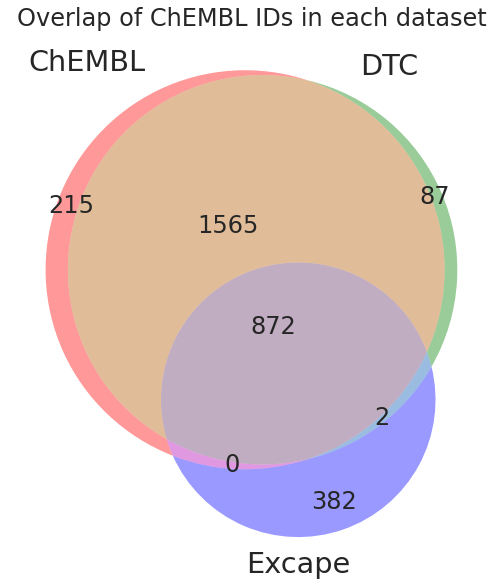

In [13]:
# venn diagram for overlapping ChEMBL IDs - mpv requires sets not lists
plt.figure()
mpv.venn3([set(chembl.Molecule_ChEMBL_ID), 
           set(dtc.compound_id), 
           set(excape.Original_Entry_ID)], 
          set_labels=['ChEMBL','DTC', 'Excape']);
plt.title('Overlap of ChEMBL IDs in each dataset');

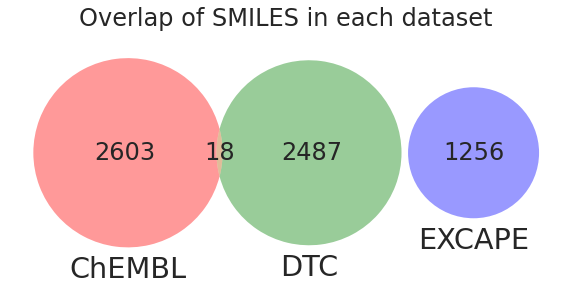

In [14]:
# overlaps from SMILES strings
plt.figure()
mpv.venn3([set(chembl.Smiles),
           set(dtc.SMILES),
           set(excape.SMILES)],
          set_labels = ['ChEMBL', 'DTC','EXCAPE']);
plt.title('Overlap of SMILES in each dataset');

The chembl IDs overlap, why not the smiles strings? One explanation is that each database's SMILES string representations are slightly different. Answer? **STANDARDIZE the smiles strings.**

## **Curation step:** Standardize smiles strings, drop rows without valid SMILES strings

In [15]:
chembl['base_rdkit_smiles'] = chembl.Smiles.apply(struct_utils.base_smiles_from_smiles)
print(len(chembl.Smiles))
print(len(chembl.Smiles.unique()))
print(len(chembl.base_rdkit_smiles.unique()))

3908
2621
2609


In [16]:
# why are there empty smiles? what are these compounds?
chembl[chembl.base_rdkit_smiles==''].head(3)

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM,base_rdkit_smiles
337,CHEMBL11359,CISPLATIN,4.0,300.05,NaN,NaN,cisplatin,NaN,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909156,"DRUGMATRIX: Histamine H1, Central radioligand ...",B,BAO_0000249,cell membrane format,NaN,NaN,NaN,CHO-K1,Membrane,NaN,NaN,NaN,CHEMBL231,Histamine H1 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307512,NaN,NaN,
358,CHEMBL1909064,LIPOPOLYSACCHARIDE E. COLI O55:B5,0.0,NaN,NaN,NaN,LIPOPOLYSACCHARIDE E. COLI O55:B5,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909156,"DRUGMATRIX: Histamine H1, Central radioligand ...",B,BAO_0000249,cell membrane format,NaN,NaN,NaN,CHO-K1,Membrane,NaN,NaN,NaN,CHEMBL231,Histamine H1 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307512,NaN,NaN,
360,CHEMBL1909069,NaN,0.0,NaN,NaN,NaN,MC 288769,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909156,"DRUGMATRIX: Histamine H1, Central radioligand ...",B,BAO_0000249,cell membrane format,NaN,NaN,NaN,CHO-K1,Membrane,NaN,NaN,NaN,CHEMBL231,Histamine H1 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307512,NaN,NaN,


In [17]:
chembl=chembl.replace('',np.nan)
chembl[chembl.base_rdkit_smiles.isna()].shape

(64, 47)

In [18]:
# drop rows without valid base_rdkit_smiles, unless you can somehow recover them
print(chembl.shape)
chembl=chembl[~chembl.base_rdkit_smiles.isna()]
print(chembl.shape)

(3908, 47)
(3844, 47)


## Examine whether there are duplicate SMILES strings

In [19]:
# chembl.columns

In [20]:
# print(chembl.base_rdkit_smiles.duplicated().sum())
cols = ['Molecule_ChEMBL_ID','Molecule_Name', 'Smiles', 'base_rdkit_smiles']

chembl[chembl.base_rdkit_smiles.duplicated(keep=False)][cols].sort_values('base_rdkit_smiles').head(3) 

,Molecule_ChEMBL_ID,Molecule_Name,Smiles,base_rdkit_smiles
4454,CHEMBL844,BRIMONIDINE,Brc1c(NC2=NCCN2)ccc2nccnc12,Brc1c(NC2=NCCN2)ccc2nccnc12
350,CHEMBL844,BRIMONIDINE,Brc1c(NC2=NCCN2)ccc2nccnc12,Brc1c(NC2=NCCN2)ccc2nccnc12
3626,CHEMBL16068,BROMOBENZENE,Brc1ccccc1,Brc1ccccc1


## Exercise: Standardize other datasets
- what do you notice about the number of unique smiles strings before and after standardization?
- what does this mean for the nature of the compounds in a given dataset?
- hint: look at chemical identifiers that have the same base_rdkit_smiles, and the 'DB' column in excape

# Let us continue the standardization with DTC


<div class="alert alert-success">
    <b>Exercise-1: DTC SMILES standardization </b>:
    <li> Look at the previous code chunks to see how we used to standardize SMILES strings. Hint: call `struct_utils.base_smiles_from_smiles`  
    <li> Print the number of SMILES entries in DTC? Of them how many are unique?
    <li> How many standardized unique SMILES entries are there in the dataset?
    <li> Replace all empty strings with NAs 
    <li> Drop all `base_rdkit_smiles` (standardized SMILES column) with NAs
</div>

<div class="alert alert-info">
    <b> Solution for Exercise-1: Try on your own. If you want to see the solution, click the following cell </b>
    
</div>

<details><summary>Click here for the solution</summary>

```python
dtc['base_rdkit_smiles'] = dtc.SMILES.apply(struct_utils.base_smiles_from_smiles)
    
print('How many SMILES entries are there in DTC? ', len(dtc.SMILES))
print('How many unique SMILES entries are there in DTC? ', len(dtc.SMILES.unique()))
print('How many standardised unique SMILES entries are there in DTC: ', 
len(dtc.base_rdkit_smiles.unique()), '\n')

# drop na smiles
# it's always better to have nan's than empty strings for downstream processing
dtc=dtc.replace('',np.nan) 

dtc=dtc[~dtc.base_rdkit_smiles.isna()]
```

</details>

In [21]:
dtc['base_rdkit_smiles'] = dtc.SMILES.apply(struct_utils.base_smiles_from_smiles)
 
print('How many SMILES entries are there in DTC? ', len(dtc.SMILES))
print('How many unique SMILES entries are there in DTC? ', len(dtc.SMILES.unique()))
print('How many standardised unique SMILES entries are there in DTC: ', 
len(dtc.base_rdkit_smiles.unique()), '\n')
 
# drop na smiles
# it's always better to have nan's than empty strings for downstream processing
dtc=dtc.replace('',np.nan) 
 
dtc=dtc[~dtc.base_rdkit_smiles.isna()]

How many SMILES entries are there in DTC?  3888
How many unique SMILES entries are there in DTC?  2505
How many standardised unique SMILES entries are there in DTC:  2492 



# Let us repeat the steps for ExCAPE 


<div class="alert alert-success">
    <b>Exercise-2: ExCAPE-DB SMILES Standardization </b>:
    <li> Look at the previous code chunks to see how we used to standardize SMILES strings. Hint: call `struct_utils.base_smiles_from_smiles`  
    <li> Print the number of SMILES entries in DTC? Of them how many are unique?
    <li> How many standardized unique SMILES entries are there in the dataset?
    <li> Replace all empty strings with NAs 
    <li> Drop all `base_rdkit_smiles` (standardized SMILES column) with NAs
</div>

<div class="alert alert-info">
    <b> Solution for Exercise-2: Try on your own. If you want to see the solution, click the following cell </b>
    
</div>

<details><summary>Click here for the solution</summary>

```python
excape['base_rdkit_smiles'] = excape.SMILES.apply(struct_utils.base_smiles_from_smiles)

print('How many SMILES entries are there in Excape? ', len(excape.SMILES))
print('How many unique SMILES entries are there in Excape? ',len(excape.SMILES.unique()))
print('How many standardised unique SMILES entries are there in Excape? ',len(excape.base_rdkit_smiles.unique()))

excape = excape.replace('',np.nan)
excape = excape[~excape.base_rdkit_smiles.isna()]
```

</details>

In [22]:
excape['base_rdkit_smiles'] = excape.SMILES.apply(struct_utils.base_smiles_from_smiles)
 
print('How many SMILES entries are there in Excape? ', len(excape.SMILES))
print('How many unique SMILES entries are there in Excape? ',len(excape.SMILES.unique()))
print('How many standardised unique SMILES entries are there in Excape? ',len(excape.base_rdkit_smiles.unique()))
 
excape = excape.replace('',np.nan)
excape = excape[~excape.base_rdkit_smiles.isna()]

How many SMILES entries are there in Excape?  1283
How many unique SMILES entries are there in Excape?  1256
How many standardised unique SMILES entries are there in Excape?  1248



<div class="alert alert-success">
    <b>Exercise-3: DTC/ExCAPE-DB Check Duplicates </b>:
    <li> After SMILES duplication, check whether there are duplicates in the 'base_rdkit_smiles' column?  Hint: Use Pandas DF duplicated command, https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html
</div>

<div class="alert alert-info">
    <b> Solution for Exercise-3: Try on your own. If you want to see the solution, click the following cell </b>
    
</div>

<details><summary>Click here for the solution</summary>

```python
# examine which smiles became the same base smiles
dtc[dtc.base_rdkit_smiles.duplicated(keep=False)][['compound_id','standard_inchi_key', 'compound_name', 'SMILES', 'base_rdkit_smiles']].sort_values('base_rdkit_smiles').head(3) 
    
excape[excape.base_rdkit_smiles.duplicated(keep=False)][['Ambit_InchiKey', 'DB', 'SMILES', 'base_rdkit_smiles']].sort_values('base_rdkit_smiles').head(3)    

```

</details>

## Hints:
- some compounds have the same inchikey or chemblid but slightly different smiles strings, because they came from 2 different databases (`DB` column in excape)
- additionally, standardization strips salts and other stabilizing molecules from the important structure. So `doxorubicin` and `doxorubicin hydrochloride` will become the same SMILES string.

# **Curation step:** save standardized datasets

In [23]:
chembl.to_csv("HRH1_ChEMBL_SMILES.csv")
dtc.to_csv("HRH1_DTC_SMILES.csv")
excape.to_csv("HRH1_Excape_SMILES.csv")

# Examine compound overlaps from standardized smiles strings
- create venn diagram with 3 circles for all 3 datasets

In [24]:
chembl = pd.read_csv("HRH1_ChEMBL_SMILES.csv", index_col=0)
dtc = pd.read_csv("HRH1_DTC_SMILES.csv", index_col=0)
excape = pd.read_csv("HRH1_Excape_SMILES.csv", index_col=0)

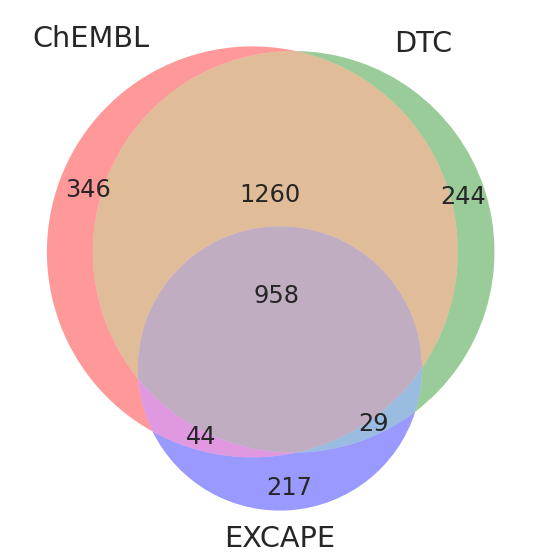

In [25]:
mpv.venn3([set(chembl.base_rdkit_smiles),
           set(dtc.base_rdkit_smiles),
           set(excape.base_rdkit_smiles)],
          set_labels = ['ChEMBL', 'DTC','EXCAPE']);

That looks reasonable! For even further overlaps, it's possible to pass all of them through the pubchem ID exchange (https://pubchem.ncbi.nlm.nih.gov/idexchange/idexchange.cgi) by using input as smiles and output as smiles, then create base_rdkit_smiles again. You should see some increase in overlap with this pre-processing step.

# EDA: Examine compound diversity

In [26]:
# chembl = pd.read_csv("~/tutorials/HRH1_ChEMBL_SMILES.csv", index_col=0)
# dtc = pd.read_csv("~/tutorials/HRH1_DTC_SMILES.csv", index_col=0)
# excape = pd.read_csv("~/tutorials/HRH1_Excape_SMILES.csv", index_col=0)

In [27]:
# all these warnings are OK
from atomsci.ddm.pipeline import diversity_plots as dp
from rdkit import Chem
from scipy.stats.kde import gaussian_kde
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoDistMat
import logging

sns.set_context('poster')
ndist_max = 1000000

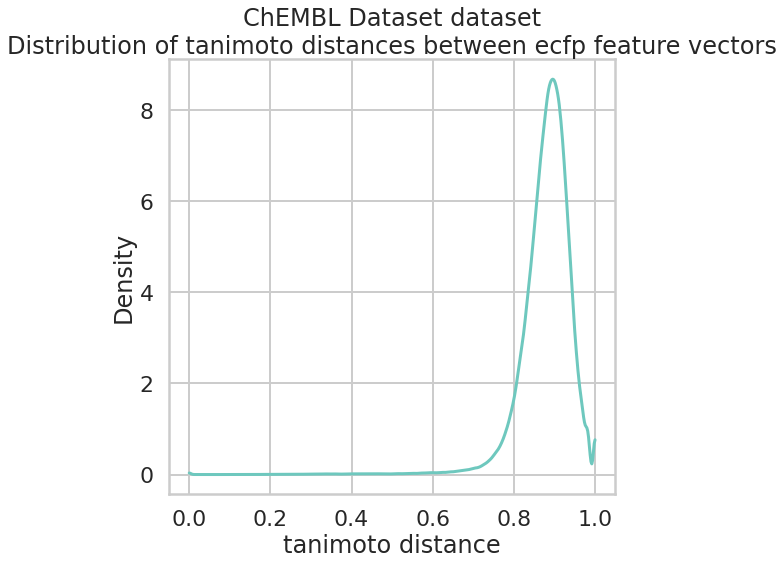

In [28]:
dp.plot_tani_dist_distr(chembl, 'base_rdkit_smiles', 'ChEMBL Dataset');

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/atomsci/ddm/pipeline/diversity_plots.py:303: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  tani_linkage = linkage(tani_dist, method='complete')


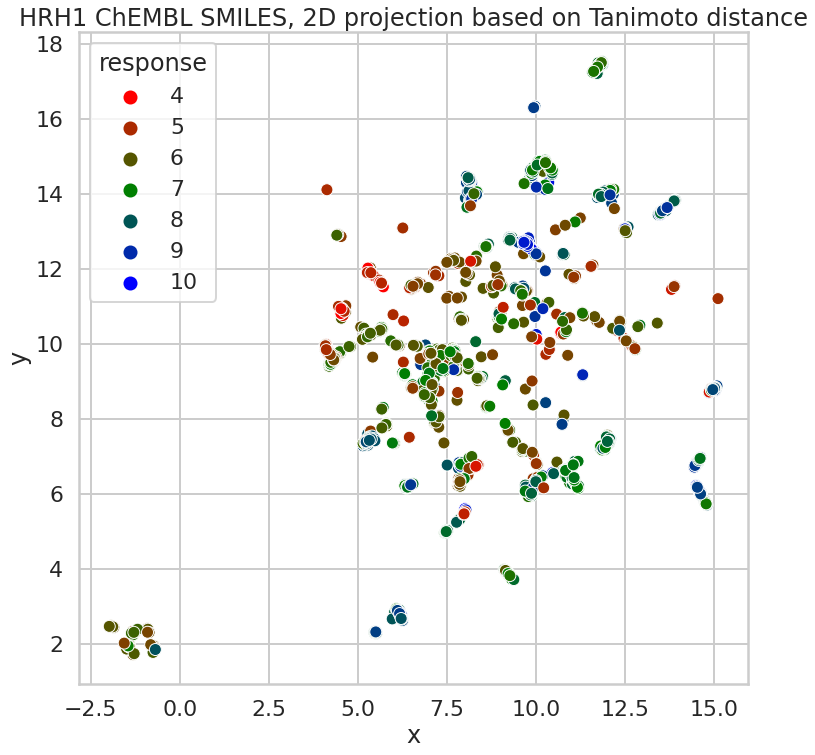

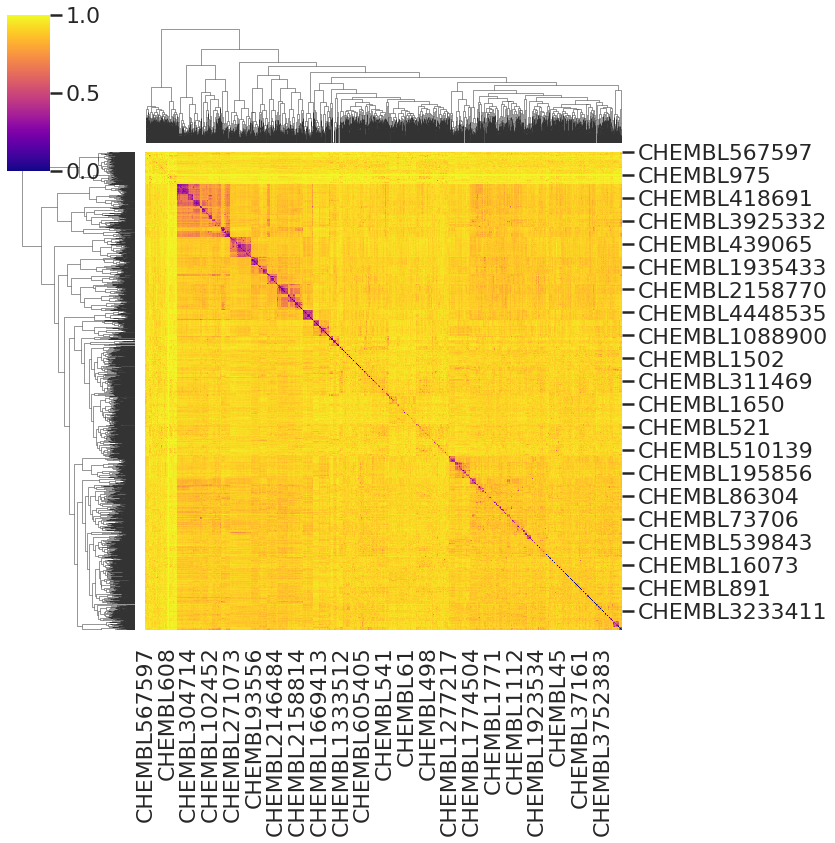

In [29]:
dp.diversity_plots('HRH1_ChEMBL_SMILES.csv', datastore=False,
                   id_col ='Molecule_ChEMBL_ID', smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, response_col = 'pChEMBL_Value', ecfp_radius=4)

# Create plots for DTC, Excape



<div class="alert alert-success">
    <b>Exercise-4: DTC compound diversity </b>:
    <li> Look at the previous code chunks for ChEMBL  
    <li> compute tanimoto distribution (Hint: use `plot_tani_dist_distr`)
    <li> use `dp.diversity_plots` to create diversity plots
</div>

<div class="alert alert-info">
    <b> Solution for Exercise-4: Try on your own. If you want to see the solution, click the following cell </b>
    
</div>

<details><summary>Click here for the solution</summary>

```python
dp.plot_tani_dist_distr(dtc, 'base_rdkit_smiles', 'DTC dataset')

dp.diversity_plots('HRH1_DTC_SMILES.csv', datastore=False,
                   id_col ='compound_id', smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, response_col = 'pDTC_Value', ecfp_radius=4)
```

</details>

## Excape compound set chemical diversity


<div class="alert alert-success">
    <b>Exercise-5: Excape-DB compound diversity </b>:
    <li> Look at the previous code chunks for ChEMBL  
    <li> compute tanimoto distribution, Hint: use `plot_tani_dist_distr`
    <li> use `dp.diversity_plots` to create diversity plots
</div>

<div class="alert alert-info">
    <b> Solution for Exercise-5: Try on your own. If you want to see the solution, click the following cell </b>
    
</div>

<details><summary>Click here for the solution</summary>

```python
dp.plot_tani_dist_distr(excape, 'base_rdkit_smiles', 'Excape dataset')

dp.diversity_plots('HRH1_Excape_SMILES.csv', datastore=False,
                   id_col ='Original_Entry_ID', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pXC50', 
                   ecfp_radius = 4)
```

</details>

## Analyze the plots. Here are few points to think about:
- what are Morgan fingerprints (ecfp)? 
  - what does radius mean?
  - what does a bit in an ECFP vector correspond to?
  - what radius and vector length are used in these functions?
  - hint: use the `?` for more info
- what is tanimoto distance? What do values closer to zero or closer to one mean?
- do you think your sets of compounds are diverse?
- what do you observe from the 2D projection of compounds?
- are there any similarities between groups of compounds in your datasets?

- ECFP fingerprints are a bit vector representation of a compound's structure. Each bit represents the presence or absence of a certain 'connectivity' between atoms in a molecule. The radius used in the diversity plots function is radius 4 and length 1024. The tanimoto plot function uses radius 2. Radius means number of atoms you travel away from the given atom to assess connectivity, allowing you to look at larger or smaller molecule fragments.
- tanimoto similarity (or jaccard index) represents how well two bit vectors overlap. Thus, distance represents how 'far' away they are from perfect overlap. A distance closer 1 means the fingerprints (and therefore molecules) are less similar to each other. A distance closer to zero means molecules are more similar. 
- My compounds have average tanimoto distances ~ 0.85 - 0.9, so they are fairly diverse.
- In the ChEMBL dataset, the 2D project separates high and low pChEMBL values very well. The DTC and Excape datasets don't separate as well, but DTC also is on a very different scale.
- From the heatmap, I can see clusters/squares of compounds with tanimoto distance closer to zero (purple) so I suspect there are some groups of compounds that are very similar.

## Questions: 
- What happens when you change the ecfp radius?
- try creating MCS plots by looking at the documentation of the diversity_plots function
- warning: it is very slow for ~ >1000 compounds. 
- Try a random subset of 1000 compounds and create the MCS plots.